# Homework 7 

Rixin Li & G . Besla



In [3]:
# Abhinav Vatsa
# 400B

In [1]:
# import necessary modules
# numpy provides powerful multi-dimensional arrays to hold and manipulate data
import numpy as np
# matplotlib provides powerful functions for plotting figures
import matplotlib.pyplot as plt
# astropy provides unit system and constants for astronomical calculations
import astropy.units as u
import astropy.constants as const
# import Latex module so we can display the results with symbols
from IPython.display import Latex
%matplotlib inline

# import CenterOfMass to determine the COM pos/vel of M33
import CenterOfMass

# import the GalaxyMass to determine the mass of M31 for each component
import GalaxyMass

MW COM Position (kpc): [-2.07  2.95 -1.45] kpc
MW COM Velocity (km/s): [ 0.94  6.32 -1.35] km / s
M31 COM Position (kpc): [-377.66  611.43 -284.64] kpc
M31 COM Velocity (km/s): [ 72.85 -72.14  49.  ] km / s
M33 COM Position (kpc): [-476.22  491.44 -412.4 ] kpc
M33 COM Velocity (km/s): [ 44.42 101.78 142.23] km / s
MW-M31 Separation: 769.098 kpc
MW-M31 Velocity: 117.738 km / s
M33-M31 Separation: 201.083 kpc
M33-M31 Velocity: 199.370 km / s

Galaxy: Milky Way
MW_000.txt
Halo Mass: 1.975 x 10^12 M☉
Disk Mass: 0.075 x 10^12 M☉
Bulge Mass: 0.01 x 10^12 M☉

Galaxy: Andromeda (M31)
M31_000.txt
Halo Mass: 1.921 x 10^12 M☉
Disk Mass: 0.12 x 10^12 M☉
Bulge Mass: 0.019 x 10^12 M☉

Galaxy: Triangulum (M33)
M33_000.txt
Halo Mass: 0.187 x 10^12 M☉
Disk Mass: 0.009 x 10^12 M☉
Bulge Mass: 0.0 x 10^12 M☉


# M33AnalyticOrbit

In [17]:
class M33AnalyticOrbit:
    """ 
    This class computes the analytical orbit of M33 around M31 using numerical integration, specifically the leapfrog method. 
    This model assumes a combination of a Hernquist halo, a Hernquist bulge, and a Miyamoto-Nagai disk for M31.
    """

    def __init__(self, filename):
        """ 
        Initializes the parameters required to compute M33's orbit around M31.
        
        Parameters:
        filename : str
            The name of the file where the computed orbit will be saved. The working directory is my Downloads folder, which is where the file should be saved on my system. 
        """
        
        # Define the gravitational constant in kpc^3 / Msun / Gyr^2
        self.G = const.G.to(u.kpc**3/u.Msun/u.Gyr**2).value
        
        # Store output filename 
        self.filename = filename
        
        # Use provided COM values (in kpc and km/s)
        # M33 COM Position (kpc)
        self.posM33 = np.array([-476.22, 491.44, -412.4])  # kpc
        # M33 COM Velocity (km/s)
        self.velM33 = np.array([44.42, 101.78, 142.23])  # km/s
        
        # M31 COM Position (kpc)
        self.posM31 = np.array([-377.66, 611.43, -284.64])  # kpc
        # M31 COM Velocity (km/s)
        self.velM31 = np.array([72.85, -72.14, 49.0])  # km/s
        
        # Compute the initial relative position and velocity vectors of M33 with respect to M31
        self.r0 = self.posM33 - self.posM31  # Relative position (kpc)
        self.v0 = self.velM33 - self.velM31  # Relative velocity (km/s)
        
        # Retrieve mass and scale lengths for M31's mass components
        self.rdisk = 5  # Scale length of the disk (kpc)
        self.Mdisk = 0.12 * 1e12  # Disk mass of M31 (Msun)
        
        self.rbulge = 1  # Scale length of the bulge (kpc)
        self.Mbulge = 0.019 * 1e12  # Bulge mass of M31 (Msun)
        
        self.rhalo = 62  # Scale length of the halo (kpc)
        self.Mhalo = 1.921 * 1e12  # Halo mass of M31 (Msun)
    
    def HernquistAccel(self, r, M, a):
        """ 
        Compute the acceleration due to a Hernquist potential. The formula for Hernquist acceleration is taken from his famous paper from 1990 for the APJ. 
        
        Parameters:
        r : ndarray
            Position vector where the acceleration is computed (kpc).
        M : float
            Mass of the component (Msun).
        a : float
            Scale length of the component (kpc).
        
        Returns:
        ndarray
            Acceleration vector (kpc/Gyr^2).
        """
        rmag = np.linalg.norm(r)  # Compute magnitude of position vector (kpc) using the norm
        return -self.G * M / (rmag * (a + rmag)**2) * r
    
    def MiyamotoNagaiAccel(self, r, M, a, b):
        """ 
        Compute the acceleration due to a Miyamoto-Nagai disk potential.
        
        Parameters:
        r : ndarray
            Position vector where the acceleration is computed (kpc).
        M : float
            Mass of the disk component (Msun).
        a : float
            Radial scale length (kpc).
        b : float
            Vertical scale length (kpc).
        
        Returns:
        ndarray
            Acceleration vector (kpc/Gyr^2).
        """
        R = np.sqrt(r[0]**2 + r[1]**2)  # Cylindrical radial distance (kpc)
        z = r[2]  # Vertical distance (kpc)
        B = np.sqrt(z**2 + b**2)  # Effective height of the disk
        
        # Compute the acceleration components using the formula provided
        factor = -self.G * M / (R**2 + (a + B)**2)**(3/2)
        return factor * np.array([r[0], r[1], (B / (B + a)) * r[2]])
    
    def M31Accel(self, r):
        """ 
        Compute the total acceleration on M33 due to M31's mass components. 
        
        Parameters:
        r : ndarray
            Position vector relative to M31 (kpc).
        
        Returns:
        ndarray
            Total acceleration vector (kpc/Gyr^2).
        """
        return (self.HernquistAccel(r, self.Mhalo, self.rhalo) +
                self.HernquistAccel(r, self.Mbulge, self.rbulge) +
                self.MiyamotoNagaiAccel(r, self.Mdisk, self.rdisk, 0.3))
    
    def LeapFrog(self, r, v, dt):
        """ 
        Perform a single step of the Leapfrog integration method.
        
        Parameters:
        r : ndarray
            Current position vector (kpc).
        v : ndarray
            Current velocity vector (kpc/Gyr).
        dt : float
            Time step (Gyr).
        
        Returns:
        tuple of ndarray
            Updated position and velocity vectors.
        """
        rhalf = r + v * (dt / 2)  # Compute half-step position
        vnew = v + self.M31Accel(rhalf) * dt  # Update velocity using acceleration at half-step
        rnew = rhalf + vnew * (dt / 2)  # Compute new position using updated velocity
        return rnew, vnew
    
    def OrbitIntegration(self, t0, dt, tmax):
        """ 
        Integrate the orbit of M33 around M31 using the Leapfrog method. This method allows for stability and backtracking.
        
        Parameters:
        t0 : float
            Initial time (Gyr).
        dt : float
            Time step (Gyr).
        tmax : float
            Maximum integration time (Gyr).
        """
        t = t0  # Initialize time
        steps = int(tmax / dt) + 1  # Number of integration steps
        orbit = np.zeros((steps, 7))  # Array to store time, position, and velocity data
        
        # Initial conditions
        orbit[0] = [t0, *self.r0, *self.v0]
        
        # Integrate the orbit in a step-by-step manner
        for i in range(1, steps):
            t += dt
            self.r0, self.v0 = self.LeapFrog(self.r0, self.v0, dt)  # Update position and velocity
            
            # Storing the new values
            orbit[i] = [t, *self.r0, *self.v0]
        
        # Save the orbit data to a file
        np.savetxt(self.filename, orbit, fmt="%11.3f"*7, comments='#',
           header="{:>10s}{:>11s}{:>11s}{:>11s}{:>11s}{:>11s}{:>11s}".format(
               't', 'x', 'y', 'z', 'vx', 'vy', 'vz'))


In [19]:
# An instance of the M33AnalyticOrbit class with a chosen filename to save the results
orbit_calculator = M33AnalyticOrbit('m33_orbit_results.txt')

# Call the OrbitIntegration method within the class with the necessary parameters. 
orbit_calculator.OrbitIntegration(t0=0, dt=0.01, tmax=100)


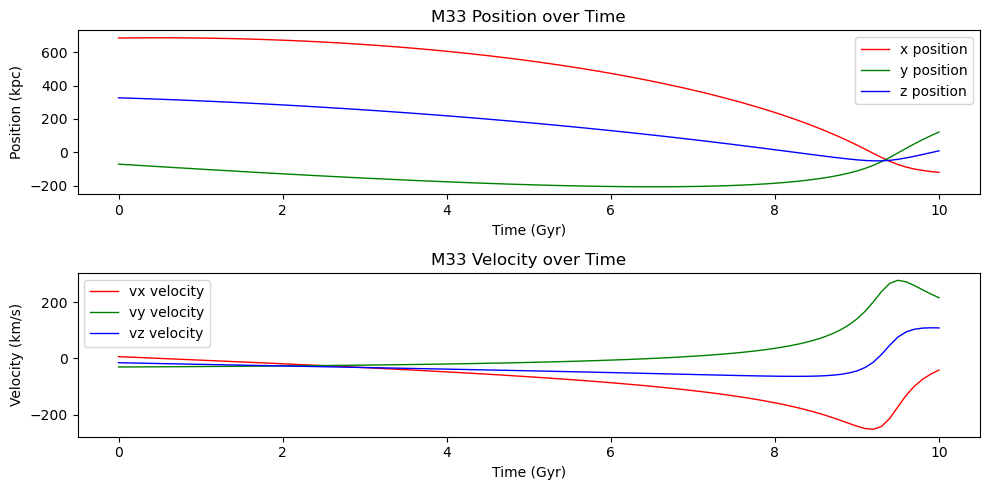

In [23]:
# We will now initialize the M33AnalyticOrbit class and compute the orbit
orbit_calculator = M33AnalyticOrbit('m33_orbit_results.txt')

# Perform the orbit integration with a time step of 0.5 Gyr for the first part of the calculation
orbit_calculator.OrbitIntegration(t0=0, dt=0.5, tmax=10)

# After verifying that the code works, we refine the integration with a smaller time step of 0.1 Gyr
orbit_calculator.OrbitIntegration(t0=0, dt=0.1, tmax=10)

# Load the orbit results from the file
orbit_data = np.loadtxt('m33_orbit_results.txt')

# Extract time, position (x, y, z), and velocity (vx, vy, vz) from the data
time = orbit_data[:, 0]  # Time (Gyr)
position = orbit_data[:, 1:4]  # Position (x, y, z) in kpc
velocity = orbit_data[:, 4:7]  # Velocity (vx, vy, vz) in km/s

# A plot to visualize the total position and velocity of M33 over time
plt.figure(figsize=(10, 5))

# Plot the position of M33 as a function of time
plt.subplot(2, 1, 1)
plt.plot(time, position[:, 0], label='x position', color='r', linestyle='-', linewidth=1)
plt.plot(time, position[:, 1], label='y position', color='g', linestyle='-', linewidth=1)
plt.plot(time, position[:, 2], label='z position', color='b', linestyle='-', linewidth=1)
plt.xlabel('Time (Gyr)')
plt.ylabel('Position (kpc)')
plt.title('M33 Position over Time')
plt.legend(loc='best')

# Plot the velocity of M33 as a function of time
plt.subplot(2, 1, 2)
plt.plot(time, velocity[:, 0], label='vx velocity', color='r', linestyle='-', linewidth=1)
plt.plot(time, velocity[:, 1], label='vy velocity', color='g', linestyle='-', linewidth=1)
plt.plot(time, velocity[:, 2], label='vz velocity', color='b', linestyle='-', linewidth=1)
plt.xlabel('Time (Gyr)')
plt.ylabel('Velocity (km/s)')
plt.title('M33 Velocity over Time')
plt.legend(loc='best')

# Adjust the layout for better visualization
plt.tight_layout()
plt.show()
